<a href="https://colab.research.google.com/github/Samir-atra/InternImage_HAN-AR/blob/master/InternImage_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InternImage for Semantic Segmentation on Colab - tutorial
This is a conversion of a local implementation of InternImage for training

TO-DO:
- Add Potsdam dataset config files to git fork of internimage?
- Test the `b` and `xl?` models


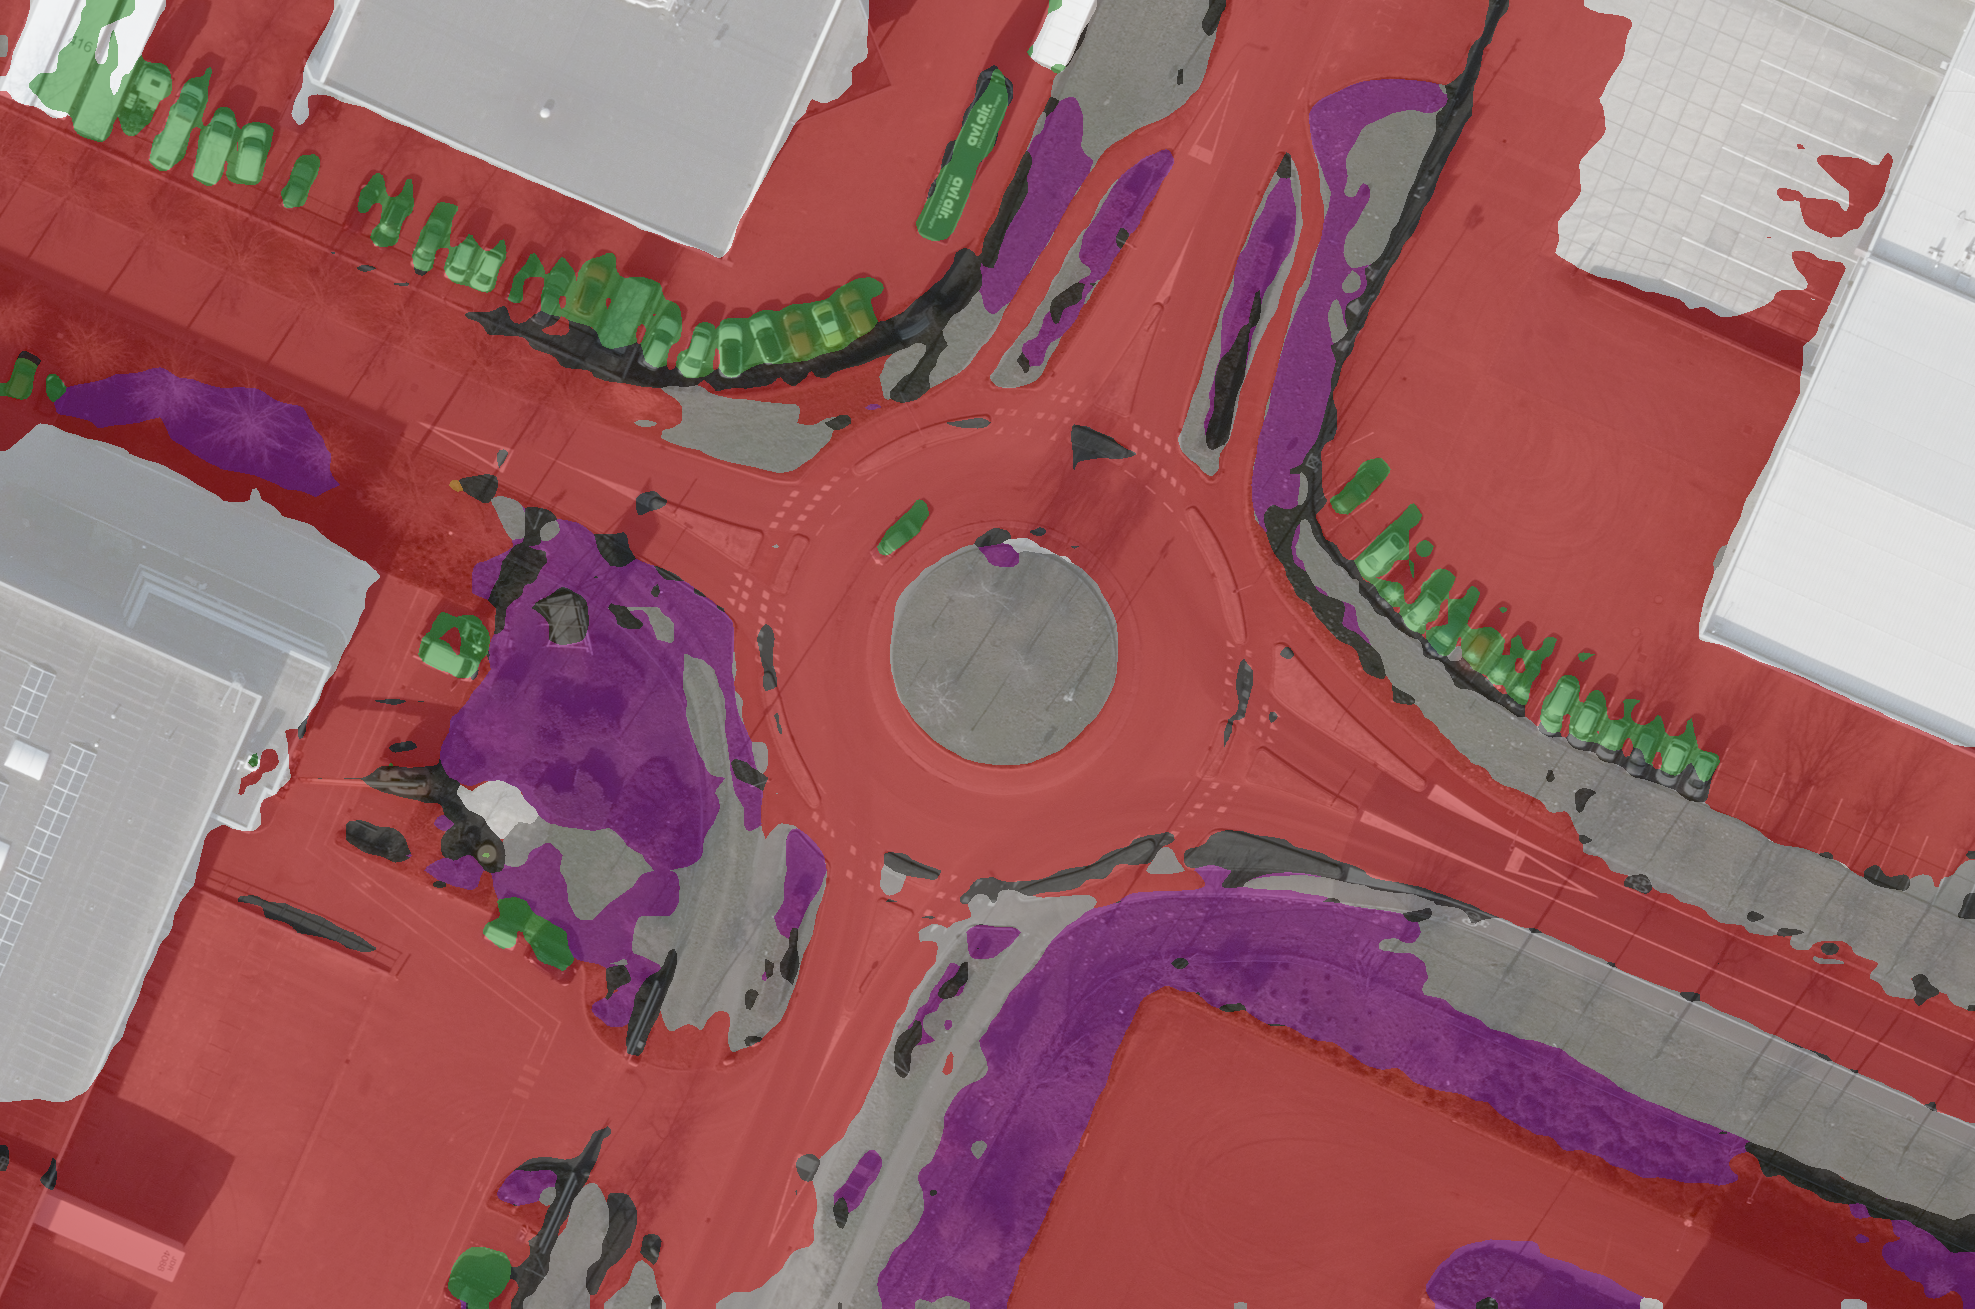

## Colab basics
Google Colab, or "Colaboratory", allows you to write and execute Python in your browser. It is a free Jupyter notebook environment that runs on VMs in the Google clould. These environments can be purely CPU based, but can also be hosted with GPU or TPU resources for accelerated processing. See the [Welcome to Colab page](https://colab.research.google.com/#scrollTo=GJBs_flRovLc) and [this community one](https://colab.research.google.com/drive/16pBJQePbqkz3QFV54L4NIkOn1kwpuRrj#scrollTo=DO6Z47v1bO-w); they both end with helpful links.

Python code can be directly written and executed in the code fields, whilst bash commands are performed with a `!` or `%` preceding the line. A `!` will run the command in a global scope (for the whole systen) while `%` commands are in the scope of the current environment and temporary subshell [[Ref 1](https://jakevdp.github.io/PythonDataScienceHandbook/01.05-ipython-and-shell-commands.html#Shell-Related-Magic-Commands), [Ref 2](https://stackoverflow.com/questions/48298146/changing-directory-in-google-colab-breaking-out-of-the-python-interpreter)].  
In practice only changing directories with `cd` is preceded by `%`.

# Setup Base Environment
Setup needed before the first run of InternImage segmentation according to [their docs](https://github.com/OpenGVLab/InternImage/tree/master/segmentation) is listed below:

* Python 3.7
  * This current version of colab uses 3.10 and it doesn't cause errors, so not a requirement
* CUDA >= 10.2
  * [Install 11.7.0](https://developer.nvidia.com/cuda-11-7-0-download-archive?target_os=Linux&target_arch=x86_64&Distribution=Ubuntu&target_version=22.04&target_type=deb_local) as this is the latest version to support PyTorch 1.13
* CuDNN >= 7
  * [Version 8.9.6](https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn-896/install-guide/index.html) is preinstalled, which is [compatible with CUDA 11.7](https://docs.nvidia.com/deeplearning/cudnn/latest/reference/support-matrix.html)
* PyTorch >= 1.10.0
  * [Install 1.13.1](https://pytorch.org/get-started/previous-versions/#wheel-8) as this is the last version before v2
* [MMCV 1.5.0](https://github.com/open-mmlab/mmcv/tree/v1.5.0)
* [MMSegmentation 0.27.0](https://github.com/open-mmlab/mmsegmentation/tree/v0.27.0)
  * New versions change functions etc. which breaks things
* [timm 0.6.11](https://github.com/huggingface/pytorch-image-models/tree/v0.6.11)
  * Py**T**orch **Im**age **M**odels (timm) is an open-source collection of state-of-the-art PyTorch image models, pretrained weights, and utility scripts for training, inference, and validation.




Check version of NVCC, cuDNN, kernel and linux release version.

In [1]:
# Check nvcc version
!nvcc -V
# Check CuDNN version
!cat /usr/include/cudnn_version.h | grep CUDNN_MAJOR -A 2
# Check GCC version
!gcc --version
# Check kernel and release version
!uname -r
# !uname -m && cat /etc/*release

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
#define CUDNN_MAJOR 8
#define CUDNN_MINOR 9
#define CUDNN_PATCHLEVEL 6
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

/* cannot use constexpr here since this is a C-only file */
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

6.1.85+


## Install prerequisites
Some packages are needed for optimal execution (not triggering warnings) but are not installed as part of setup scripts. Additionally, NVIDIA driver/CUDA install asks for user interaction to set keyboard country, so set this without user input using the `DEBIAN_FRONTEND=noninteractive` command.

If you just directly run these commands it gets stuck at `apt-get -y install cuda` as there is user input requested to define the keyboard/input type. This can be avoided with `DEBIAN_FRONTEND=noninteractive ...` as seen below, which is from [this SO answer](https://askubuntu.com/a/1006187). See also [[Ref 1](https://stackoverflow.com/questions/77671348/how-to-create-a-non-interactive-env-to-prevent-the-cuda-questioncountry-of-ori), [Ref 2](https://stackoverflow.com/a/43290817/5809639), [Ref 3](https://github.com/apptainer/singularity/issues/5768)].

Due to the system configuration and version of MMCV being used, it is built from source.
Within the [docs for building from source](https://mmcv.readthedocs.io/en/v1.5.0/get_started/build.html) it is recommended to install `ninja` to speed up compilation.
This also affects the `make` command used to build Deformable Convolutional Network (DCN) v3 within the InternImage repo.
Later versions [of the docs](https://mmcv.readthedocs.io/en/latest/get_started/build.html) also recommend installing `psutil`.

In [2]:
# Install verison of prerequisite to use 'verify' keyword
!pip install yapf==0.40.1
# Install ninja & psutil to speed up mmcv compilation and DCNv3 make
!pip install ninja psutil
# Perform setup to avoid interaction pauses
!DEBIAN_FRONTEND=noninteractive apt-get install keyboard-configuration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 6.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  liblocale-gettext-perl
The following NEW packages will be installed:
  keyboard-configuration liblocale-gettext-perl
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 223 kB of archives.
After this operation, 923 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 liblocale-gettext-perl amd64 1.07-4build3 [17.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 keyboard-configuration all 1.205ubuntu3 [206 kB]
Fetched 223 kB in 1s (323 kB/s)
Preconfiguring packages ...
Selecting previously unselected package liblocale-gettext-perl.
(Reading database ... 123597 files and directories currently installed

## Install CUDA 11.7
These are the commands from the NVIDA installation instructions [on this page](https://developer.nvidia.com/cuda-11-7-0-download-archive?target_os=Linux&target_arch=x86_64&Distribution=Ubuntu&target_version=22.04&target_type=deb_local).

Unlike most instuctions ([such as in NVIDIA docs](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html#handle-conflicting-installation-methods)), it is not advisable to first uninstall the existing verison of CUDA as this ends up causing more problems than it solves.


In [3]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
!mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/11.7.0/local_installers/cuda-repo-ubuntu2204-11-7-local_11.7.0-515.43.04-1_amd64.deb
!dpkg -i cuda-repo-ubuntu2204-11-7-local_11.7.0-515.43.04-1_amd64.deb
!cp /var/cuda-repo-ubuntu2204-11-7-local/cuda-*-keyring.gpg /usr/share/keyrings/
!apt-get update
!apt-get -y install cuda-11-7
!apt autoremove
# Check nvcc version
!nvcc -V

--2024-09-01 00:22:14--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu2204.pin’

cuda-ubuntu2204.pin 100%[===================>]     190  --.-KB/s    in 0s      

2024-09-01 00:22:14 (3.08 MB/s) - ‘cuda-ubuntu2204.pin’ saved [190/190]

--2024-09-01 00:22:14--  https://developer.download.nvidia.com/compute/cuda/11.7.0/local_installers/cuda-repo-ubuntu2204-11-7-local_11.7.0-515.43.04-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 O

### Set version of CUDA to use
After installing the required version of CUDA (11.7), select it as default using `update-alternatives`.

In [4]:
!update-alternatives --set cuda $(update-alternatives --list cuda | grep cuda-11.7)
# Check nvcc version to show change
!nvcc -V

update-alternatives: using /usr/local/cuda-11.7 to provide /usr/local/cuda (cuda) in manual mode
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:49:14_PDT_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0


## Install PyTorch
The pip wheel install commands are listed on [the official website](https://pytorch.org/get-started/previous-versions/#v1131) (PyTorch 1.13.1 with CUDA 11.7)

In [5]:
!pip uninstall -y torchtext   #Remove incompatible versions
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117
# Print CUDA version available to PyTorch and device name
import torch
print(f"CUDA version {torch.version.cuda} on "
      f"{torch.cuda.get_device_name(torch.cuda.current_device())}")

"""Restart run time before next cell"""

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 864.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0+cu121
    Uninstalling torch-2.4.0+cu121:
      Successfully uninstalled torch-2.4.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.19.0+cu121
    Uninstalling torchvision-0.19.0+cu121:
      Successfully uninstalled torchvision-0.19.0+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.4.0+cu121
    Uninstalling torchaudio-2.4.0+cu121:
      Successfully uninstalled torchaudio-2.4.0+cu121


RuntimeError: No CUDA GPUs are available

## Install MMCV using MIM
Just doing it as mentioned in the [InterImage docs](https://github.com/OpenGVLab/InternImage/tree/master/segmentation), split into two code sections as pip encounters issues (mentioned below).

### Install MIM
This is a tool which provides a unified interface for launching and installing OpenMMLab projects and their extensions, and managing the OpenMMLab model zoo. - [OpenMMLab on GitHub](https://github.com/open-mmlab/mim)

In [ ]:
# Install MIM
!pip install -U openmim

#### Restart session for imported packages
The MIM install usually causes a warning and tells to restart the session. Do that here.

Specifically the error and warning is:
```
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.4 requires setuptools>65.5.1, but you have setuptools 60.2.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.28.2 which is incompatible.
yfinance 0.2.40 requires requests>=2.31, but you have requests 2.28.2 which is incompatible.
Successfully installed aliyun-python-sdk-core-2.15.1 aliyun-python-sdk-kms-2.16.3 colorama-0.4.6 crcmod-1.7 jmespath-0.10.0 model-index-0.1.11 opendatalab-0.0.10 openmim-0.3.9 openxlab-0.1.0 ordered-set-4.1.0 oss2-2.17.0 pycryptodome-3.20.0 requests-2.28.2 rich-13.4.2 setuptools-60.2.0 tqdm-4.65.2 urllib3-1.26.18

WARNING: The following packages were previously imported in this runtime:
  [_distutils_hack,pkg_resources,setuptools,tqdm]
You must restart the runtime in order to use newly installed versions.
```
Maybe installing jedi earlier fixes this?

### Install MMCV and timm
Install MMCV 1.5.0, MMSegmentation 0.27, timm 0.6.11 and MMDetection 2.28.1 as described in the Internimage install documentation.

In [ ]:
# Install MMCV using MIM
!mim install mmcv-full==1.5.0
!mim install mmsegmentation==0.27.0
!pip install timm==0.6.11 mmdet==2.28.1

Clone mmsegmentation repo for the easy `image_demo`

Earlier text below:
Intall from source  
Based on the [mmsegmentation installation instructions for 0.27](https://github.com/open-mmlab/mmsegmentation/blob/v0.27.0/docs/en/get_started.md#installation) (also see [the docs page version](https://mmsegmentation.readthedocs.io/en/0.x/get_started.html#installation) with different formatting) but this does not have anything to specify which version to install, so when following these instructions the latest version is installed.

In [ ]:
mmseg_repo_path = "/content/drive/MyDrive/Colab Notebooks/data_upload/mmsegmentation/"
if os.path.isdir(mmseg_repo_path):
  print("Folder exists.")
  %cd /content/drive/MyDrive/Colab Notebooks/data_upload/mmsegmentation
else:
  %cd /content/drive/MyDrive/Colab Notebooks/data_upload/
  !git clone https://github.com/open-mmlab/mmsegmentation.git --branch v0.27.0
  %cd mmsegmentation

## Verify installation

In [ ]:
# print Python version
!python --version
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

### Run MMSeg with pretrained weight

In [ ]:
# Checkpoint for v0.x of mmseg
!mim download mmsegmentation --config pspnet_r50-d8_512x1024_40k_cityscapes --dest .
# Demo when installing from source
!python demo/image_demo.py demo/demo.png \
  configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py \
  pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth \
  --device cuda:0 --out-file result.jpg

In [ ]:
# Show result
from IPython.display import Image
Image('result.jpg')

# Setup InternImage
Now MMSeg is installed, setup internimage

In [ ]:
#Get out of mmseg folder
%cd ..
repo_path = "/content/drive/MyDrive/Colab Notebooks/data_upload/InternImage_HAN-AR/"
if os.path.isdir(repo_path):
  print("Folder exists.")
  %cd /content/drive/MyDrive/Colab Notebooks/data_upload/InternImage_HAN-AR/
else:
  # Clone my fork
  # !git clone https://github.com/OpenGVLab/InternImage.git
  %cd /content/drive/MyDrive/Colab Notebooks/data_upload/
  !git clone https://github.com/Samir-atra/InternImage_HAN-AR.git
  %cd InternImage_HAN-AR

## Compile CUDA operators for DCN v3
Mentioned in the [install docs](https://github.com/OpenGVLab/InternImage/tree/master/segmentation)




In [ ]:
# Compile CUDA operators
%cd segmentation/ops_dcnv3
!sh ./make.sh
# unit test (should see all checking is True)
!python test.py
# Change back to segmentation folder
%cd ..

## Verify setup
Above works!

### Download checkpoint for testing

In [ ]:
# Download large checkpoint
!mkdir checkpoints
!wget -P ./checkpoints https://huggingface.co/OpenGVLab/InternImage/resolve/main/upernet_internimage_l_512x1024_160k_mapillary2cityscapes.pth

### Download sample image
Get a sample image for testing of a roundabout

In [ ]:
from PIL import Image
import requests
# From https://stock.adobe.com/nl/search?k=roundabout+aerial
url = 'https://as2.ftcdn.net/v2/jpg/00/93/69/79/1000_F_93697965_f6k92wNmoO6gNjqiOxQPfLRerq453nQZ.jpg'
im = Image.open(requests.get(url, stream=True).raw)
im.save("./test_roundabout_img.jpg")
im

### Run inference on sample image
Run it

In [ ]:
# Change to correct folder
%cd ..
%cd segmentation
# Run
!CUDA_VISIBLE_DEVICES=0 python image_demo.py ./test_roundabout_img.jpg \
  configs/cityscapes/upernet_internimage_l_512x1024_160k_mapillary2cityscapes.py \
  checkpoints/upernet_internimage_l_512x1024_160k_mapillary2cityscapes.pth --palette cityscapes

In [ ]:
# Show result
from IPython.display import Image
Image('demo/test_roundabout_img.jpg')

# Prepare data
The data is the [Okutama-Swiss Drone Dataset](https://www.okutama-segmentation.org/).

It takes quite some time (especially on limited Colab CPUs) to perform the extraction and conversion of the dataset, so try and load it from Google Drive.
If not on Google drive, download the dataset and run processing script.


In [ ]:
# # Testing without GPU
# import torch;print(torch.__version__)
# # Install MMCV
# !pip install -U openmim
# !mim install mmcv
# # Get script for processing data
# !git clone https://github.com/HAN-AR/InternImage.git
# %cd InternImage/segmentation

In [ ]:
import os, shutil
# Mount Google Drive (if not mounted)
if os.path.isdir('//content/drive'):
  print("Google drive already mounted.")
else:
  from google.colab import drive
  drive.mount('//content/drive')

# Make dir
!mkdir data

# Define path where extracted and processed data is stored
data_path = "//content/drive/MyDrive/Colab Notebooks/data_upload/Okutama-Swiss-dataset/"
if os.path.isdir(data_path):
  print("Folder exists. Copying...")
  shutil.copytree(data_path, "data/Okutama-Swiss-dataset")
  print("Done!")
else:
  # Get data
  !wget -P data/ https://okutama-segmentation-dataset.s3.ap-northeast-1.amazonaws.com/Okutama-Swiss-dataset.zip
  # Process
  !python tools/convert_okutama_swiss.py data/Okutama-Swiss-dataset.zip
  # Copy to gDrive so processing can be skipped in future
  shutil.copytree("data/Okutama-Swiss-dataset", data_path)

# Train InternImage
All prep done, now train!

How can I make this not a waste of time when it stops after 5 minutes because setup took so long?


Connect to Google drive to store checkpoints as training will not complete before timeout maybe requires editing train.py?

Comparing training of the large model... ETA is about 3.8 days on the Tesla T4, compared to just under 1 day on the desktop.
Which makes it pointless, unless this can also handle training the XL model?

In [ ]:
!python train.py configs/custom/upernet_internimage_l_512x512_160k_swiss_okutama.py --cfg-options data.workers_per_gpu=2 --auto-resume

- editing the repository to be cloned.
- Setting the directories to work across accounts and cut the downloads to minimum.
- add the auto-resume option
- need to run and debug the paths